In [227]:
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
np.random.seed(9)

class NN(object):
    def __init__(self, inputlayer_neurons, hiddenlayer_neurons, output_neurons, weights=None):
        # network variable initialization
        self.inputlayer_neurons = inputlayer_neurons
        self.hiddenlayer_neurons = hiddenlayer_neurons
        self.output_neurons =  output_neurons
        
        # setting inital average instantaneous energy to be some value greater than 1
        self.E_avg = 10
        # arrays to store average energy and epochs
        self.E_avg_per_epoch = np.array([])
        self.epochs = np.array([])
        
        # if no weights are passed then initalize weights to random values
        # or if weights are given intialize the weights to the given weights
        if weights == None:
            self.wh = np.random.random(size=(self.inputlayer_neurons,self.hiddenlayer_neurons))
            self.bh = np.random.random(size=(1,hiddenlayer_neurons))
            self.wout = np.random.random(size=(hiddenlayer_neurons,output_neurons))
            self.bout = np.random.random(size=(1,output_neurons))
        else:
            weights_values = list(weights.values())
            self.wh = weights_values[0]
            self.bh = weights_values[1]
            self.wout = weights_values[2]
            self.bout = weights_values[3]
            
        
    # sigmoid function
    def sigmoid(x):
        return 1/(1 + np.exp(-x))

    # derivative of sigmoid function
    def derivatives_sigmoid(x):
        return x*(1-x)
    
    # feed forward and prediction
    # x - input data
    def predict(self,x):
        hidden_layer_input1 = np.dot(x,self.wh)
        hidden_layer_input = hidden_layer_input1 + self.bh
        hiddenlayer_activations = sigmoid(hidden_layer_input)
        output_layer_input1 = np.dot(hiddenlayer_activations,self.wout)
        output_layer_input = output_layer_input1 + self.bout
        output = sigmoid(output_layer_input)
        return hiddenlayer_activations, output
    
    # online backpropogation which returns average error energy for every run
    # train the network
    # X - input data
    # Y - output corresponding to X
    # lr - learining rate
    # mt - momentum term
    def backPropogate(self,X,Y,lr,mt):
        # initialize delta weights of (k-1) sample to zero first
        delta_wout_previous = np.zeros_like(self.wout)
        delta_bout_previous = np.zeros_like(self.bout)
        delta_wh_previous = np.zeros_like(self.wh)
        delta_bh_previous = np.zeros_like(self.bh)
        
        # initialize sum of instantaneous energy per epoch to be zero
        E_sum = 0    
        
        # for every sample in input dataset X
        for x,y in zip(X,Y):
            x = np.array([x])
            #Forward Propogation
            hiddenlayer_activations, output = self.predict(x)
            
            # calculate error
            e = y - output
            
            # slope of outputs is nothing but the devivaties
            slope_output_layer = derivatives_sigmoid(output)
            slope_hidden_layer = derivatives_sigmoid(hiddenlayer_activations)
            
            
            local_gradient_output = e * slope_output_layer
            delta_wout = (delta_wout_previous * mt) + (hiddenlayer_activations.T.dot(local_gradient_output) * lr)
            delta_bout = (delta_bout_previous * mt) + (np.sum(local_gradient_output, axis=0, keepdims=True) * lr)
        
            error_hidden_layer = local_gradient_output.dot(wout.T)
            local_gradient_hidden = error_hidden_layer * slope_hidden_layer
        
            delta_wh = (delta_wh_previous) + (x.T.dot(local_gradient_hidden) * lr)
            delta_bh = (delta_bh_previous) + (np.sum(local_gradient_hidden, axis=0, keepdims=True) * lr)
        
            # updating the weights
            self.wout += delta_wout
            self.bout += delta_bout

            self.wh += delta_wh 
            self.bh += delta_bh 
            
            # setting current weights as previuos for the next input sample
            delta_wout_previous = delta_wout
            delta_bout_previous = delta_bout
            delta_wh_previous = delta_wh
            delta_bh_previous = delta_bh
            
            # calcualting instantaneous energy and adding it to the sum
            E = (e**2)/2
            E_sum += E
        
        # calculate average instantaneous energy for each epoch and return the value
        E_avg = E_sum/(len(X))
        return E_avg
    
    # train the network
    # X - input data
    # Y - output corresponding to X
    # lr - learining rate
    # mt - momentum term
    # E_avg_threshold - average energy threshold at which you want to stop training the network
    def train(self, X, Y, lr, mt, E_avg_threshold):
        i = 0
        # average instantaneous energy is more than the threshold given
        while(self.E_avg > E_avg_threshold):
            # calling backpropogate method of the class
            self.E_avg = self.backPropogate(X, Y, lr, mt)
            # appending the average error energy and epochs to arrays 
            # we will use this later to plot the graph
            self.E_avg_per_epoch = np.append(self.E_avg_per_epoch, self.E_avg)
            self.epochs = np.append(self.epochs, i)
            i += 1
            # after each epoch randomize the inputs given
            X, Y = shuffle(X, Y, random_state=0)
        return i, self.E_avg
    
    # plot average error energy per epoch
    def plotErrAvgVsEpochs(self):
        plt.plot(self.epochs, self.E_avg_per_epoch)
        plt.xlabel("epochs")
        plt.ylabel("Average error energy")
        plt.show()
        
    # plot decision boundary
    # X - input data
    # Y - output corresponding to X
    def plotDecisionBoundary(self,X,Y):
        x = np.reshape(X[:,0:1], 314,)
        y = np.reshape(X[:,1:2], 314,)

        x_min, x_max = x.min() - 1, x.max() + 1
        y_min, y_max = y.min() - 1, y.max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.2), np.arange(y_min, y_max, 0.2))
        plotData = np.c_[xx.ravel(), yy.ravel()]
        
        hiddenLayerOutput, output = self.predict(plotData)
        output = output.reshape(xx.shape)
        
        # plot contour decision boundary 
        plt.contourf(xx, yy, output)
        #plt.axis('off')
        # scatter input data points
        plt.scatter(x,y,c=Y,cmap=plt.cm.Paired)
        plt.show()
    

In [228]:
lr = 0.7 # setting learning rate
mt = 0.1 # momentum term

# read data from input file
in_data_from_file = genfromtxt('cross_data.csv', delimiter=',', dtype=float)
# separate the read data into input and output
X = in_data_from_file[...,:2]
Y = in_data_from_file[...,2:]

# read weights from the files
wh = genfromtxt('w1.csv', delimiter=',', dtype=float).T
bh = np.array([genfromtxt('b1.csv', delimiter=',', dtype=float)])
wout = np.array([genfromtxt('w2.csv', delimiter=',', dtype=float)]).T
bout = np.array([[genfromtxt('b2.csv', delimiter=',', dtype=float)]])

# prepare a dictionary of weights
weights = dict()
weights['wh'] = wh
weights['bh'] = bh
weights['wout'] = wout
weights['bout'] = bout

# create an object of NN class by setting the model parameter
# no of neurons in input layer, no of neurons in hidden
# layer, no of neurons in output layer and finally pass the
# dictionary of weights and bias
nn = NN(2, 10, 1, weights)

# pass intput data, corresponding output, learning rate, 
# momentum term and average error energy at which we want 
# to stop training the network
nn.train(X,Y,lr,mt,0.001)

(26, array([[ 0.00097887]]))

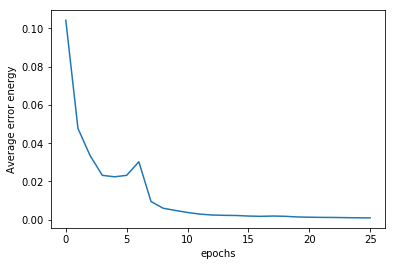

In [229]:
# plotting average energy versus no fo epochs
nn.plotErrAvgVsEpochs()

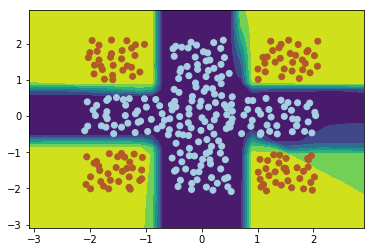

In [230]:
# plto decision boundary after training
nn.plotDecisionBoundary(X,Y)